In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sb
import statsmodels as sm
import numpy as np
%matplotlib inline

Loading the data:

In [164]:
os.chdir('/home/pbellec/data/zooqc')
data = pd.read_csv(filepath_or_buffer='brain-match-classifications_11-dec-2016 - brain-match-classifications.csv');

Filter out all entries corresponding to users that were not logged in (we are left with 1262 ratings)

In [165]:
data = data[ (data.user_name.str.find("not-logged-in")==-1)]

data.shape

(1262, 14)

Only include the rows corresponding to anatomical workflows (we are left with 913 ratings)

In [166]:
data = data [ (data.workflow_name.str.find("anatomical")>0) ]
data.shape

(913, 14)

Small histogram of the number of ratings per user. The vast majority of them only rated a couple images, making their contribution likely useless. 

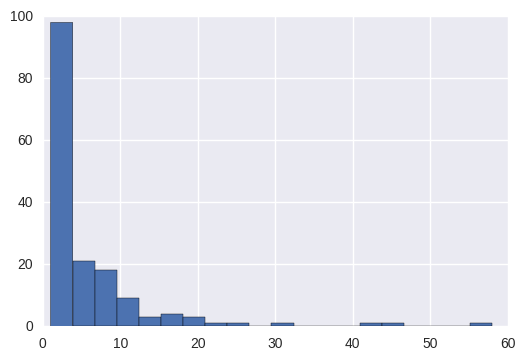

In [167]:
user_count = data.user_name.value_counts()
user_count.hist(bins=20)

Keep only users with at least 10 ratings (we are left with 25 raters):

In [169]:
list_user = user_count.index
list_user = list_user[user_count.values>=10]
print(list_user.shape)
user_count[user_count.values>=10]

(25,)


EcceruElme           58
KazzaY               46
Yassinebha           43
asko_oksa            30
simexp               24
Liisika              23
CDawgUnleashed       19
Chris5420            19
WEBs_in_space        19
Kroth                17
MishySee             17
Lostasagoose         16
jschott5             16
nhaberman            15
141Dial34            13
sapphira80           13
joncarruthers        12
Manny936             12
OldWoodchuck         12
kryswolf             12
DFK1951              12
elainelwright        11
MBeeHH               11
Danielle_Gonalves    10
Ros_Stannard         10
Name: user_name, dtype: int64

Keep only the ratings made by these users. Make a histogram of the number of ratings per image. 

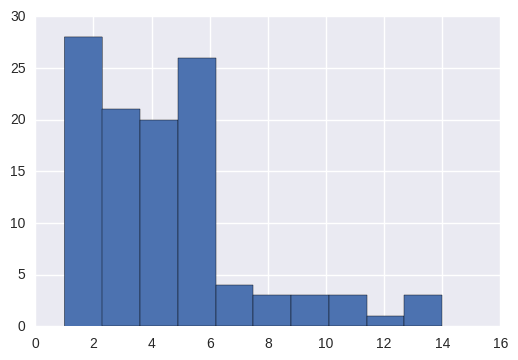

In [170]:
data = data[data.user_name.isin(list_user)]
image_count = data.subject_ids.value_counts()
image_count.hist()

So this is not great. Most images have been rated less than 5 times, making for highly volatile majority vote. Because different raters rated each image (in general...), it is not possible to compute a kappa measure of agreement. We are going to keep only images with at least 5 ratings (there are 43 of them):

In [174]:
list_image = image_count.index
list_image = list_image[image_count>=5]
image_count = image_count[image_count>=5]
list_image.shape

(43,)

We are now going to build a data frame with the number of OK/Maybe/Fail rating for each image:

In [175]:
list_status = { "OK" , "Maybe" , "Fail"}
stats = pd.DataFrame(index=list_image,columns=list_status)
for status in list_status:
    for image in stats.index:
        stats[status][image] = sum( (data.subject_ids==image) & (data.annotations.str.find(status)>0))  
stats

,Fail,Maybe,OK
3865382,1,4,9
3865549,5,5,3
3865319,1,3,9
3865459,1,5,6
3865366,1,1,9
3865486,4,1,6
3865334,1,3,7
3865497,9,0,1
3865541,9,0,1
3865411,1,3,5


Now let's normalize the number of ratings in each category (ok/maybe/fail) by the number of raters:

In [176]:
nb_rating = stats.sum(axis="columns")
for status in list_status:
    for image in stats.index:
        stats[status][image] = stats[status][image]/nb_rating[image]

Histogram of the frequency of the "fail" rating across raters, for all images. If all raters agreed, we would only have 0% or 100% rating frequencies. 

<Container object of 10 artists>

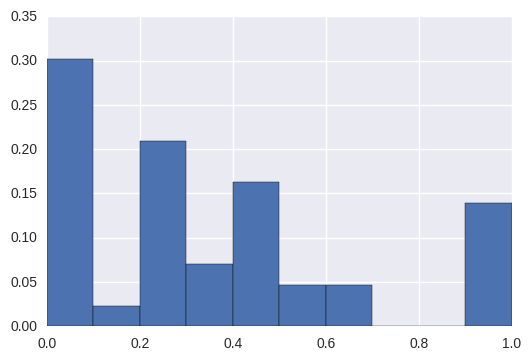

In [177]:
hfail , bins = np.histogram(stats.Fail,bins=np.arange(0,1.1,0.1))
hfail = hfail.astype(np.float32) / hfail.sum()
plt.bar(bins[:-1], hfail , width=(bins[1]-bins[0]))

Not fantastic but not bad either. There seems to be some images that are unambiguously failures (we had 25% of "fail" case in the database). But there is quite a large grey zone. 

Histogram of the frequency of the "OK" and "Maybe" rating across raters, for all images. If all raters agreed, we would only have 0% or 100% rating frequencies.

<Container object of 10 artists>

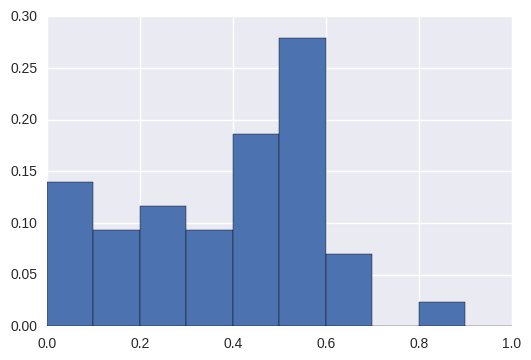

In [178]:
hok , bins = np.histogram(stats.OK,bins=np.arange(0,1.1,0.1))
hok = hok.astype(np.float32) / hok.sum()
plt.bar(bins[:-1], hok , width=(bins[1]-bins[0]))

<Container object of 10 artists>

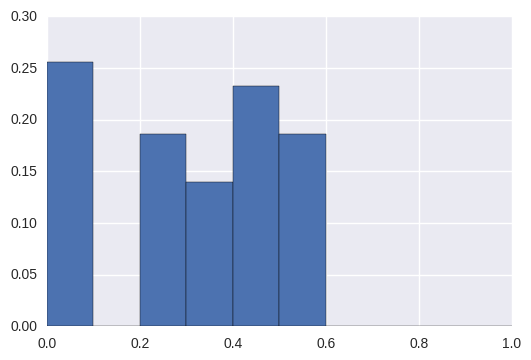

In [179]:
hmaybe , bins = np.histogram(stats.Maybe,bins=np.arange(0,1.1,0.1))
hmaybe = hmaybe.astype(np.float32) / hmaybe.sum()
plt.bar(bins[:-1], hmaybe , width=(bins[1]-bins[0]))

It's all over the map! We need to improve on this for the "OK"/"Maybe" guidelines to be useful.